In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from numpy import argmax
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from tqdm import tqdm
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
import collections
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import pandas as pd

In [2]:
import numpy as np

In [4]:
animal = pd.read_csv("../data/animal_smiles_r_v3.csv")
animal = animal[animal["smiles_r"]!="Cannot_do"].reset_index(drop=True)
animal


,CHEMISTRY,NAME,human_CL_mL_min_kg,rat_CL_mL_min_kg,dog_CL_mL_min_kg,monkey_CL_mL_min_kg,human_VDss_L_kg,rat_VDss_L_kg,dog_VDss_L_kg,monkey_VDss_L_kg,human_fup,rat_fup,dog_fup,monkey_fup,smiles_r,InChICode_standardised,molecular_weight_smiles_r
0,Fc1c[nH]c(=O)[nH]c1=O,5-Fluorouracil,26.0,33.0,NaN,NaN,0.23,0.25,NaN,NaN,0.6400,0.690,NaN,NaN,O=c1[n-]cc(F)c(=O)[n-]1,"InChI=1S/C4H3FN2O2/c5-2-1-6-4(9)7-3(2)8/h1H,(H...",128.003303
1,[nH]1cnc(=S)c(c12)[nH]cn2,6-Mercaptopurine,15.0,NaN,NaN,15.2,1.00,NaN,NaN,0.9,0.8500,NaN,NaN,NaN,S=c1nc[n-]c2nc[n-]c12,InChI=1S/C5H3N4S/c10-5-3-4(7-1-6-3)8-2-9-5/h1-...,150.001114
2,CO[C@@H]1[C@H](NC)C[C@@H](O2)n(c3c4n5[C@]12C)c...,7-Hydroxystaurosporine,0.0,65.0,10.20,NaN,0.15,16.70,6.09,NaN,0.0022,NaN,0.0074,NaN,C[NH2+][C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3c...,InChI=1S/C28H26N4O4/c1-28-25(35-3)15(29-2)12-1...,483.202682
3,C1OC(=O)[C@](O)(CC)c(c12)cc3n(c2=O)Cc4c3nc5c(c...,9-Aminocamptothecin,6.5,150.0,NaN,NaN,2.20,5.00,NaN,NaN,0.0030,NaN,NaN,NaN,CC[C@@]1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3c(N)cccc...,InChI=1S/C20H17N3O4/c1-2-20(26)13-7-16-17-10(6...,363.121906
4,OC[C@@H]1C=C[C@@H](C1)n(cn2)c(c23)nc(N)nc3NC4CC4,Abacavir,13.0,30.0,NaN,NaN,0.84,NaN,NaN,NaN,0.5000,NaN,NaN,NaN,Nc1nc([NH2+]C2CC2)c2ncn([C@H]3C=C[C@@H](CO)C3)...,InChI=1S/C14H18N6O/c15-14-18-12(17-9-2-3-9)11-...,287.161486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,OC[C@@H](O)[C@@H](O)[C@H]1[C@H](NC(=O)C)[C@H](...,Zamivir,1.6,31.7,NaN,NaN,0.23,0.80,NaN,NaN,0.8600,NaN,NaN,NaN,CC(=O)N[C@H]1[C@H]([C@H](O)[C@H](O)CO)OC(C(=O)...,InChI=1S/C12H20N4O7/c1-4(18)15-8-5(16-12(13)14...,332.133199
367,[N-]=[N+]=N[C@H]1C[C@@H](O[C@@H]1CO)n2cc(C)c(=...,Zidovudine,25.0,25.1,14.00,NaN,1.80,0.86,1.00,NaN,0.8000,0.687,0.8270,0.707,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...,InChI=1S/C10H13N5O4/c1-5-3-15(10(18)12-9(5)17)...,266.089477
368,OP(=O)(O)C(O)(P(=O)(O)O)Cn1ccnc1,Zoledronic Acid,2.2,NaN,4.13,NaN,0.60,NaN,0.28,NaN,0.7800,NaN,NaN,NaN,O=P([O-])([O-])C(O)(Cn1ccnc1)P(=O)([O-])[O-],"InChI=1S/C5H10N2O7P2/c8-5(15(9,10)11,16(12,13)...",267.967218
369,O=C1OC[C@@H](N1)Cc(cc2)cc(c23)c(c[nH]3)CCN(C)C,Zolmitriptan,6.7,29.4,NaN,NaN,1.80,3.53,NaN,NaN,0.7500,NaN,NaN,NaN,C[NH+](C)CCc1c[nH]c2ccc(C[C@H]3COC(=O)N3)cc12,InChI=1S/C16H21N3O2/c1-19(2)6-5-12-9-17-15-4-3...,288.170653


In [6]:

dog = animal[["InChICode_standardised", "smiles_r", "dog_VDss_L_kg" , "dog_CL_mL_min_kg", "dog_fup"]].dropna(subset=["dog_VDss_L_kg" , "dog_CL_mL_min_kg", "dog_fup"], how="all").reset_index(drop=True)
dog.loc[dog["dog_CL_mL_min_kg"] == '#REF!', "dog_CL_mL_min_kg"] = np.nan
dog["dog_CL_mL_min_kg"] = dog["dog_CL_mL_min_kg"].astype("float")
dog

,InChICode_standardised,smiles_r,dog_VDss_L_kg,dog_CL_mL_min_kg,dog_fup
0,InChI=1S/C28H26N4O4/c1-28-25(35-3)15(29-2)12-1...,C[NH2+][C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3c...,6.09,10.20,0.0074
1,InChI=1S/C15H23N3O2/c1-4-18(5-2)11-10-16-15(20...,CC[NH+](CC)CCNC(=O)c1ccc(NC(C)=O)cc1,1.90,6.40,0.9135
2,InChI=1S/C8H9NO2/c1-6(10)9-7-2-4-8(11)5-3-7/h2...,CC(=O)Nc1ccc([O-])cc1,0.58,4.00,0.8900
3,InChI=1S/C5H7ClN2O3/c6-3-1-2(11-8-3)4(7)5(9)10...,[NH3+]C(C(=O)[O-])[C@@H]1CC(Cl)=NO1,0.58,1.40,NaN
4,InChI=1S/C23H35N3O/c1-17(2)25(18(3)4)16-14-23(...,CC1=[NH+]C(=O)[C@](CC[NH+](C(C)C)C(C)C)(c2cccc...,1.30,12.00,0.6180
...,...,...,...,...,...
259,InChI=1S/C16H14F3N5O/c1-10(15-14(19)5-20-7-22-...,CC(c1ncncc1F)[C@](O)(Cn1cncn1)c1ccc(F)cc1F,0.88,1.50,0.4900
260,InChI=1S/C14H20N2O3/c17-13(15-12-8-4-3-5-9-12)...,O=C(CCCCCCC(O)=NO)Nc1ccccc1,0.60,54.70,0.4581
261,InChI=1S/C19H16O4/c1-12(20)11-15(13-7-3-2-4-8-...,CC(=O)CC(c1ccccc1)c1c([O-])c2ccccc2oc1=O,0.28,0.30,NaN
262,InChI=1S/C10H13N5O4/c1-5-3-15(10(18)12-9(5)17)...,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...,1.00,14.00,0.8270


In [4]:
animal_sparsity= animal[['rat_CL_mL_min_kg',
       'dog_CL_mL_min_kg', 'monkey_CL_mL_min_kg', 
       'rat_VDss_L_kg', 'dog_VDss_L_kg', 'monkey_VDss_L_kg',
       'rat_fup', 'dog_fup', 'monkey_fup']]
animal_sparsity

,rat_CL_mL_min_kg,dog_CL_mL_min_kg,monkey_CL_mL_min_kg,rat_VDss_L_kg,dog_VDss_L_kg,monkey_VDss_L_kg,rat_fup,dog_fup,monkey_fup
0,33.0,NaN,NaN,0.25,NaN,NaN,0.690,NaN,NaN
1,NaN,NaN,15.2,NaN,NaN,0.9,NaN,NaN,NaN
2,65.0,10.20,NaN,16.70,6.09,NaN,NaN,0.0074,NaN
3,150.0,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN
4,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
366,31.7,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN
367,25.1,14.00,NaN,0.86,1.00,NaN,0.687,0.8270,0.707
368,NaN,4.13,NaN,NaN,0.28,NaN,NaN,NaN,NaN
369,29.4,NaN,NaN,3.53,NaN,NaN,NaN,NaN,NaN


In [5]:
#convert each column to SparseArray
sparr = animal_sparsity.iloc[:, :].apply(pd.arrays.SparseArray)
print(1 - sparr.sparse.density)

0.4486373165618448


In [6]:
sparr

,rat_CL_mL_min_kg,dog_CL_mL_min_kg,monkey_CL_mL_min_kg,rat_VDss_L_kg,dog_VDss_L_kg,monkey_VDss_L_kg,rat_fup,dog_fup,monkey_fup
0,33.0,NaN,NaN,0.25,NaN,NaN,0.690,NaN,NaN
1,NaN,NaN,15.2,NaN,NaN,0.9,NaN,NaN,NaN
2,65.0,10.20,NaN,16.70,6.09,NaN,NaN,0.0074,NaN
3,150.0,NaN,NaN,5.00,NaN,NaN,NaN,NaN,NaN
4,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
366,31.7,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN
367,25.1,14.00,NaN,0.86,1.00,NaN,0.687,0.8270,0.707
368,NaN,4.13,NaN,NaN,0.28,NaN,NaN,NaN,NaN
369,29.4,NaN,NaN,3.53,NaN,NaN,NaN,NaN,NaN


In [7]:
dog

,InChICode_standardised,smiles_r,dog_VDss_L_kg,dog_CL_mL_min_kg,dog_fup
0,InChI=1S/C28H26N4O4/c1-28-25(35-3)15(29-2)12-1...,C[NH2+][C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3c...,6.09,10.20,0.0074
1,InChI=1S/C15H23N3O2/c1-4-18(5-2)11-10-16-15(20...,CC[NH+](CC)CCNC(=O)c1ccc(NC(C)=O)cc1,1.90,6.40,0.9135
2,InChI=1S/C8H9NO2/c1-6(10)9-7-2-4-8(11)5-3-7/h2...,CC(=O)Nc1ccc([O-])cc1,0.58,4.00,0.8900
3,InChI=1S/C5H7ClN2O3/c6-3-1-2(11-8-3)4(7)5(9)10...,[NH3+]C(C(=O)[O-])[C@@H]1CC(Cl)=NO1,0.58,1.40,NaN
4,InChI=1S/C23H35N3O/c1-17(2)25(18(3)4)16-14-23(...,CC1=[NH+]C(=O)[C@](CC[NH+](C(C)C)C(C)C)(c2cccc...,1.30,12.00,0.6180
...,...,...,...,...,...
259,InChI=1S/C16H14F3N5O/c1-10(15-14(19)5-20-7-22-...,CC(c1ncncc1F)[C@](O)(Cn1cncn1)c1ccc(F)cc1F,0.88,1.50,0.4900
260,InChI=1S/C14H20N2O3/c17-13(15-12-8-4-3-5-9-12)...,O=C(CCCCCCC(O)=NO)Nc1ccccc1,0.60,54.70,0.4581
261,InChI=1S/C19H16O4/c1-12(20)11-15(13-7-3-2-4-8-...,CC(=O)CC(c1ccccc1)c1c([O-])c2ccccc2oc1=O,0.28,0.30,NaN
262,InChI=1S/C10H13N5O4/c1-5-3-15(10(18)12-9(5)17)...,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...,1.00,14.00,0.8270


In [8]:
inchi = dog[["InChICode_standardised", "smiles_r"]]
for endpoint in ["dog_VDss_L_kg","dog_CL_mL_min_kg"]:
    print("Transformed endpoint to log base 10")
    dog[endpoint] = np.log10(dog[endpoint])
dog

Transformed endpoint to log base 10
Transformed endpoint to log base 10


,InChICode_standardised,smiles_r,dog_VDss_L_kg,dog_CL_mL_min_kg,dog_fup
0,InChI=1S/C28H26N4O4/c1-28-25(35-3)15(29-2)12-1...,C[NH2+][C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3c...,0.784617,1.008600,0.0074
1,InChI=1S/C15H23N3O2/c1-4-18(5-2)11-10-16-15(20...,CC[NH+](CC)CCNC(=O)c1ccc(NC(C)=O)cc1,0.278754,0.806180,0.9135
2,InChI=1S/C8H9NO2/c1-6(10)9-7-2-4-8(11)5-3-7/h2...,CC(=O)Nc1ccc([O-])cc1,-0.236572,0.602060,0.8900
3,InChI=1S/C5H7ClN2O3/c6-3-1-2(11-8-3)4(7)5(9)10...,[NH3+]C(C(=O)[O-])[C@@H]1CC(Cl)=NO1,-0.236572,0.146128,NaN
4,InChI=1S/C23H35N3O/c1-17(2)25(18(3)4)16-14-23(...,CC1=[NH+]C(=O)[C@](CC[NH+](C(C)C)C(C)C)(c2cccc...,0.113943,1.079181,0.6180
...,...,...,...,...,...
259,InChI=1S/C16H14F3N5O/c1-10(15-14(19)5-20-7-22-...,CC(c1ncncc1F)[C@](O)(Cn1cncn1)c1ccc(F)cc1F,-0.055517,0.176091,0.4900
260,InChI=1S/C14H20N2O3/c17-13(15-12-8-4-3-5-9-12)...,O=C(CCCCCCC(O)=NO)Nc1ccccc1,-0.221849,1.737987,0.4581
261,InChI=1S/C19H16O4/c1-12(20)11-15(13-7-3-2-4-8-...,CC(=O)CC(c1ccccc1)c1c([O-])c2ccccc2oc1=O,-0.552842,-0.522879,NaN
262,InChI=1S/C10H13N5O4/c1-5-3-15(10(18)12-9(5)17)...,Cc1cn([C@H]2C[C@H](N=[N+]=[N-])[C@@H](CO)O2)c(...,0.000000,1.146128,0.8270


In [9]:
dog = dog.groupby('smiles_r').median().reset_index()
dog

,smiles_r,dog_VDss_L_kg,dog_CL_mL_min_kg,dog_fup
0,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,1.394452,1.489958,NaN
1,C#CC[NH+](C)[C@H](C)Cc1ccccc1,0.975891,2.204120,NaN
2,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...,1.230449,1.397940,NaN
3,C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=...,-0.619789,-0.397940,0.0700
4,C=CC1C[NH+]2CC[C@H]1CC2C(O)c1ccnc2ccc(OC)cc12,0.572872,0.909021,0.0096
...,...,...,...,...
259,[NH3+]CCC(O)C(=O)N[C@@H]1C[C@H]([NH3+])[C@@H](...,-0.698970,0.544068,NaN
260,[NH3+]Cc1ccccc1CC(=O)NC1C(=O)[NH+]2C(C(=O)[O-]...,-0.301030,0.812913,NaN
261,[NH3+][C@@H](CC(=O)[NH+]1CCn2c(nnc2C(F)(F)F)C1...,0.518514,0.959041,0.5561
262,[O-]c1ccc2c(c1)[C@]13CCCC[C@@]1(O)[C@H](C2)[NH...,0.924279,1.763428,0.3687


In [10]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

def fs_variance(df, threshold:float=0.05):
    """
    Return a list of selected variables based on the threshold.
    """

    # The list of columns in the data frame
    features = list(df.columns)
    
    # Initialize and fit the method
    vt = VarianceThreshold(threshold = threshold)
    _ = vt.fit(df)
    
    # Get which column names which pass the threshold
    feat_select = list(compress(features, vt.get_support()))
    
    return feat_select

def get_pairwise_correlation(population_df, method="pearson"):
    """Given a population dataframe, calculate all pairwise correlations.
    Parameters
    ----------
    population_df : pandas.core.frame.DataFrame
        Includes metadata and observation features.
    method : str, default "pearson"
        Which correlation matrix to use to test cutoff.
    Returns
    -------
    list of str
        Features to exclude from the population_df.
    """


    # Get a symmetrical correlation matrix
    data_cor_df = population_df.corr(method=method)

    # Create a copy of the dataframe to generate upper triangle of zeros
    data_cor_natri_df = data_cor_df.copy()

    # Replace upper triangle in correlation matrix with NaN
    data_cor_natri_df = data_cor_natri_df.where(
        np.tril(np.ones(data_cor_natri_df.shape), k=-1).astype(np.bool)
    )

    # Acquire pairwise correlations in a long format
    # Note that we are using the NaN upper triangle DataFrame
    pairwise_df = data_cor_natri_df.stack().reset_index()
    pairwise_df.columns = ["pair_a", "pair_b", "correlation"]

    return data_cor_df, pairwise_df

def determine_high_cor_pair(correlation_row, sorted_correlation_pairs):
    """
    Select highest correlated variable given a correlation row with columns:
    ["pair_a", "pair_b", "correlation"]
    For use in a pandas.apply()
    """

    pair_a = correlation_row["pair_a"]
    pair_b = correlation_row["pair_b"]

    if sorted_correlation_pairs.get_loc(pair_a) > sorted_correlation_pairs.get_loc(pair_b):
        return pair_a
    
    else:
        return pair_b
    
def count(pred, true, min, max, endpoint):

    if(endpoint == "dog_fup"):
        lst = [abs(a/b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    else:
        lst = [abs(10**a/10**b) for a, b in zip(pred, true)]
        #print(lst)

        newlist = [x for x in lst if min <= x <= max]
        #print(newlist)

        return (len(newlist)/len(lst)) *100
    
    return

def calc_gmfe(pred, true, endpoint):
    
    if(endpoint == "dog_fup"):
        
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        return (10**mean_abs)
    
    else: 
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        mean_abs= np.mean(lst)
        
        return (10** mean_abs)
    
    return
                         
def median_fold_change_error(pred, true, endpoint):
                         
    if (endpoint == "dog_fup"):
        lst = [abs(np.log10(a/b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    else:
        lst = [abs(np.log10(10**a/10**b)) for a, b in zip(pred, true)]
        median_abs= np.median(lst) 
        return (np.e**median_abs)
    
    return
                          
def calc_bias(pred, true, endpoint):
                          
    if (endpoint == "dog_fup"):
        lst = [(a - b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    else:
        lst = [(10**a - 10**b) for a, b in zip(pred, true)]                 
        bias= np.median(lst)
        return bias
    
    return

In [11]:
smiles_r = dog[["smiles_r"]]
smiles_r

,smiles_r
0,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
1,C#CC[NH+](C)[C@H](C)Cc1ccccc1
2,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...
3,C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=...
4,C=CC1C[NH+]2CC[C@H]1CC2C(O)c1ccnc2ccc(OC)cc12
...,...
259,[NH3+]CCC(O)C(=O)N[C@@H]1C[C@H]([NH3+])[C@@H](...
260,[NH3+]Cc1ccccc1CC(=O)NC1C(=O)[NH+]2C(C(=O)[O-]...
261,[NH3+][C@@H](CC(=O)[NH+]1CCn2c(nnc2C(F)(F)F)C1...
262,[O-]c1ccc2c(c1)[C@]13CCCC[C@@]1(O)[C@H](C2)[NH...


In [12]:
from rdkit import Chem
from mordred import Calculator, descriptors

# create descriptor calculator with all descriptors
calc = Calculator(descriptors, ignore_3D=True)

print(len(calc.descriptors))

Ser_Mol = dog['smiles_r'].apply(Chem.MolFromSmiles)

# as pandas
Mordred_table=  calc.pandas(Ser_Mol)

1613


100%|████████████████████████████████████████| 264/264 [00:01<00:00, 164.30it/s]


In [13]:
Mordred_table = Mordred_table.astype('float')
Mordred_table['smiles_r'] = dog['smiles_r']

In [14]:
len(Mordred_table.columns[Mordred_table.isna().any()].tolist())

390

In [15]:
Mordred_table = Mordred_table.dropna(axis='columns')
selected_Features = fs_variance(Mordred_table .iloc[:,:-1], threshold=0.05)
print(len(selected_Features))
new_Mordred_table = Mordred_table [selected_Features]
# Get correlation matrix and lower triangle of pairwise correlations in long format
data_cor_df, pairwise_df = get_pairwise_correlation(population_df=new_Mordred_table)
# Get absolute sum of correlation across features
# The lower the index, the less correlation to the full data frame
# We want to drop features with highest correlation, so drop higher index
variable_cor_sum = data_cor_df.abs().sum().sort_values().index
# And subset to only variable combinations that pass the threshold
pairwise_df = pairwise_df.query("correlation > 0.95")
excluded = pairwise_df.apply(lambda x: determine_high_cor_pair(x, variable_cor_sum), axis="columns")
excluded_features = list(set(excluded.tolist()))
print(len(excluded_features))
new_Mordred_table = new_Mordred_table.drop(excluded_features, axis=1)
max_feature_values = new_Mordred_table.max().abs()
min_feature_values = new_Mordred_table.min().abs()
#outlier_features = max_feature_values[(max_feature_values > 15) | (min_feature_values > 15)].index.tolist()
#print(len(outlier_features))
#new_Mordred_table = new_Mordred_table.drop(outlier_features, axis=1)
new_Mordred_table['smiles_r'] = dog['smiles_r']
new_Mordred_table

799
416


/tmp/ipykernel_1345974/1157293658.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.tril(np.ones(data_cor_natri_df.shape), k=-1).astype(np.bool)


,nAcid,nBase,SpDiam_A,VE1_A,VR2_A,VR3_A,nBridgehead,nHetero,nH,nC,...,GGI5,GGI6,GGI8,Diameter,MWC10,SRW03,SRW09,TSRW10,mZagreb1,smiles_r
0,1.0,0.0,4.952581,3.888933,14.362248,6.544103,0.0,2.0,27.0,20.0,...,1.861111,0.346122,0.205593,10.0,11.807615,0.0,0.000000,56.111877,11.180556,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
1,0.0,1.0,4.453621,3.435097,4.491949,4.477816,0.0,1.0,18.0,13.0,...,0.229167,0.122449,0.032754,9.0,10.478217,0.0,0.000000,44.372474,5.333333,C#CC[NH+](C)[C@H](C)Cc1ccccc1
2,1.0,0.0,5.164227,4.066097,7.841830,5.938972,0.0,2.0,23.0,20.0,...,0.864722,0.600862,0.184681,11.0,12.482571,0.0,7.234898,72.152610,7.291667,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...
3,2.0,1.0,5.145634,3.878794,37.509554,8.124405,0.0,14.0,14.0,16.0,...,1.531667,0.848209,0.504433,14.0,12.328339,0.0,6.555357,79.747558,11.833333,C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=...
4,0.0,1.0,4.989896,4.427587,7.170811,6.023541,2.0,4.0,25.0,20.0,...,0.930556,0.487347,0.172336,12.0,12.138056,0.0,0.000000,59.266606,7.000000,C=CC1C[NH+]2CC[C@H]1CC2C(O)c1ccnc2ccc(OC)cc12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0.0,4.0,4.964979,5.326006,11.817599,7.544764,0.0,18.0,47.0,22.0,...,1.826389,1.665306,0.842278,15.0,12.488447,0.0,0.000000,77.280899,17.388889,[NH3+]CCC(O)C(=O)N[C@@H]1C[C@H]([NH3+])[C@@H](...
260,4.0,2.0,5.144988,3.914143,38.741860,8.465032,0.0,15.0,21.0,20.0,...,1.552222,0.729796,0.574956,18.0,12.428636,0.0,6.555357,85.480519,12.194444,[NH3+]Cc1ccccc1CC(=O)NC1C(=O)[NH+]2C(C(=O)[O-]...
261,0.0,2.0,4.851495,3.906670,24.521313,7.561367,0.0,12.0,17.0,16.0,...,0.805556,0.779683,0.296564,15.0,12.096152,0.0,6.861711,77.585634,11.423611,[NH3+][C@@H](CC(=O)[NH+]1CCn2c(nnc2C(F)(F)F)C1...
262,1.0,1.0,5.339943,4.119583,10.440525,6.399217,2.0,3.0,29.0,21.0,...,1.034722,0.584490,0.073066,11.0,12.678595,0.0,0.000000,60.334421,6.291667,[O-]c1ccc2c(c1)[C@]13CCCC[C@@]1(O)[C@H](C2)[NH...


In [16]:
Ser_Mol = dog['smiles_r'].apply(Chem.MolFromSmiles)

import numpy as np
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

Morgan_fingerprint= Ser_Mol.apply(GetMorganFingerprintAsBitVect, args=(2, 2048))
Morganfingerprint_array  = np.stack(Morgan_fingerprint)

Morgan_collection  = []
for x in np.arange(Morganfingerprint_array.shape[1]): #np.arange plus rapide que range
    x = "Mfp"+str(x)
    Morgan_collection.append(x)

Morganfingerprint_table  = pd.DataFrame(Morganfingerprint_array , columns=Morgan_collection )
Morganfingerprint_table['smiles_r'] = dog['smiles_r']

In [17]:
selected_Features = fs_variance(Morganfingerprint_table.iloc[:,:-1], threshold=0.05)
print(len(selected_Features))
new_Morganfingerprint_table= Morganfingerprint_table[selected_Features]
new_Morganfingerprint_table['smiles_r'] = dog['smiles_r']
new_Morganfingerprint_table

169


/tmp/ipykernel_1345974/3997023141.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_Morganfingerprint_table['smiles_r'] = dog['smiles_r']


,Mfp1,Mfp13,Mfp80,Mfp114,Mfp116,Mfp117,Mfp118,Mfp140,Mfp147,Mfp150,...,Mfp1928,Mfp1963,Mfp1970,Mfp1980,Mfp1991,Mfp2010,Mfp2021,Mfp2031,Mfp2038,smiles_r
0,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,C#CC[NH+](C)[C@H](C)Cc1ccccc1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...
3,1,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=...
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,C=CC1C[NH+]2CC[C@H]1CC2C(O)c1ccnc2ccc(OC)cc12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[NH3+]CCC(O)C(=O)N[C@@H]1C[C@H]([NH3+])[C@@H](...
260,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[NH3+]Cc1ccccc1CC(=O)NC1C(=O)[NH+]2C(C(=O)[O-]...
261,1,0,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,[NH3+][C@@H](CC(=O)[NH+]1CCn2c(nnc2C(F)(F)F)C1...
262,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,[O-]c1ccc2c(c1)[C@]13CCCC[C@@]1(O)[C@H](C2)[NH...


In [18]:
Mordred_columns = new_Mordred_table.columns[:-1].tolist()
mfp_columns = new_Morganfingerprint_table.columns[:-1].tolist()
#Mordred_columns = Mordred_table.columns[:-1].tolist()
#mfp_columns = Morganfingerprint_table.columns[:-1].tolist()

features_mfp_mordred_columns = Mordred_columns + mfp_columns
print(len(features_mfp_mordred_columns))

#Write to file
#len(features_mfp_mordred_columns)
f = open("features_mfp_mordred_columns_dog_model.txt", "w")
for item in features_mfp_mordred_columns:
   f.write(item + "\n")
f.close()

552


In [19]:
#read from file
file = open("features_mfp_mordred_columns_dog_model.txt", "r")
file_lines = file.read()
features_mfp_mordred_columns = file_lines.split("\n")
features_mfp_mordred_columns = features_mfp_mordred_columns[:-1]
features_mfp_mordred_columns

['nAcid',
 'nBase',
 'SpDiam_A',
 'VE1_A',
 'VR2_A',
 'VR3_A',
 'nBridgehead',
 'nHetero',
 'nH',
 'nC',
 'nN',
 'nO',
 'nS',
 'nF',
 'nX',
 'ATS4dv',
 'ATS6dv',
 'ATS8dv',
 'ATS2s',
 'ATS3s',
 'ATS4s',
 'ATS5s',
 'ATS6s',
 'ATS7s',
 'ATS8s',
 'ATS1m',
 'ATS4m',
 'ATS8m',
 'ATS6i',
 'ATS8i',
 'AATS1dv',
 'AATS3dv',
 'AATS4dv',
 'AATS0d',
 'AATS2d',
 'AATS3d',
 'AATS4d',
 'AATS1s',
 'AATS2s',
 'AATS3s',
 'AATS4s',
 'AATS0m',
 'AATS1m',
 'AATS2m',
 'AATS3m',
 'AATS4m',
 'AATS0v',
 'AATS3v',
 'AATS4v',
 'AATS1are',
 'AATS2are',
 'AATS3are',
 'AATS4are',
 'AATS0i',
 'AATS1i',
 'AATS2i',
 'AATS3i',
 'AATS4i',
 'ATSC0c',
 'ATSC1c',
 'ATSC2c',
 'ATSC3c',
 'ATSC4c',
 'ATSC5c',
 'ATSC6c',
 'ATSC7c',
 'ATSC8c',
 'ATSC0dv',
 'ATSC1dv',
 'ATSC2dv',
 'ATSC3dv',
 'ATSC4dv',
 'ATSC5dv',
 'ATSC6dv',
 'ATSC7dv',
 'ATSC8dv',
 'ATSC1d',
 'ATSC2d',
 'ATSC3d',
 'ATSC4d',
 'ATSC5d',
 'ATSC6d',
 'ATSC7d',
 'ATSC8d',
 'ATSC1s',
 'ATSC2s',
 'ATSC3s',
 'ATSC4s',
 'ATSC5s',
 'ATSC6s',
 'ATSC7s',
 'ATSC8s',
 'ATS

In [20]:
dog_mfp = pd.merge(dog, new_Morganfingerprint_table)
dog_mfp_Mordred = pd.merge(dog_mfp, new_Mordred_table)
dog_mfp_Mordred

#human_lombardo_mfp = pd.merge(human_lombardo, Morganfingerprint_table)
#human_lombardo_mfp_Mordred = pd.merge(human_lombardo_mfp, Mordred_table)
#human_lombardo_mfp_Mordred

,smiles_r,dog_VDss_L_kg,dog_CL_mL_min_kg,dog_fup,Mfp1,Mfp13,Mfp80,Mfp114,Mfp116,Mfp117,...,GGI4,GGI5,GGI6,GGI8,Diameter,MWC10,SRW03,SRW09,TSRW10,mZagreb1
0,C#CCCCC(=O)c1cc(C(C)(C)C)c([O-])c(C(C)(C)C)c1,1.394452,1.489958,NaN,0,0,1,1,0,0,...,1.680000,1.861111,0.346122,0.205593,10.0,11.807615,0.0,0.000000,56.111877,11.180556
1,C#CC[NH+](C)[C@H](C)Cc1ccccc1,0.975891,2.204120,NaN,1,0,1,0,0,0,...,0.551111,0.229167,0.122449,0.032754,9.0,10.478217,0.0,0.000000,44.372474,5.333333
2,C#C[C@]1(O)CC[C@H]2[C@@H]3CCc4cc([O-])ccc4[C@H...,1.230449,1.397940,NaN,0,0,0,0,0,0,...,1.898333,0.864722,0.600862,0.184681,11.0,12.482571,0.0,7.234898,72.152610,7.291667
3,C=CC1=C(C(=O)[O-])[NH+]2C(=O)C(=NC(=O)C(NOCC(=...,-0.619789,-0.397940,0.0700,1,0,1,0,0,0,...,2.089444,1.531667,0.848209,0.504433,14.0,12.328339,0.0,6.555357,79.747558,11.833333
4,C=CC1C[NH+]2CC[C@H]1CC2C(O)c1ccnc2ccc(OC)cc12,0.572872,0.909021,0.0096,1,0,0,0,0,0,...,1.671111,0.930556,0.487347,0.172336,12.0,12.138056,0.0,0.000000,59.266606,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,[NH3+]CCC(O)C(=O)N[C@@H]1C[C@H]([NH3+])[C@@H](...,-0.698970,0.544068,NaN,1,0,1,0,0,0,...,3.546667,1.826389,1.665306,0.842278,15.0,12.488447,0.0,0.000000,77.280899,17.388889
260,[NH3+]Cc1ccccc1CC(=O)NC1C(=O)[NH+]2C(C(=O)[O-]...,-0.301030,0.812913,NaN,0,0,1,0,1,0,...,2.506667,1.552222,0.729796,0.574956,18.0,12.428636,0.0,6.555357,85.480519,12.194444
261,[NH3+][C@@H](CC(=O)[NH+]1CCn2c(nnc2C(F)(F)F)C1...,0.518514,0.959041,0.5561,1,0,1,1,0,0,...,2.307778,0.805556,0.779683,0.296564,15.0,12.096152,0.0,6.861711,77.585634,11.423611
262,[O-]c1ccc2c(c1)[C@]13CCCC[C@@]1(O)[C@H](C2)[NH...,0.924279,1.763428,0.3687,0,0,1,0,0,0,...,2.346667,1.034722,0.584490,0.073066,11.0,12.678595,0.0,0.000000,60.334421,6.291667


dog_VDss_L_kg
0
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=42)
50
2-fold :  68.0
3-fold :  78.0
5-fold :  84.0
gmfe :  2.140764481199292
mfe :  1.1759090160200742
bias :  0.06492024675795188
rmse  0.5170440766336888
r2  0.06933316262838385
saving model


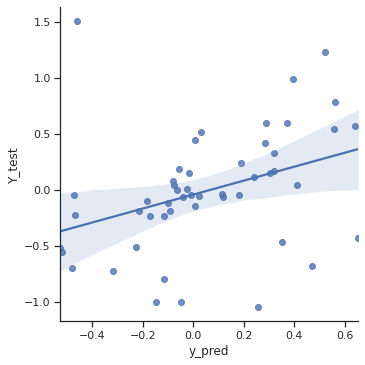

1
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=42)
50
2-fold :  70.0
3-fold :  84.0
5-fold :  92.0
gmfe :  1.8402309201052842
mfe :  1.2089605619709018
bias :  0.12215521395096557
rmse  0.3481198355718725
r2  0.5665323034743555
saving model


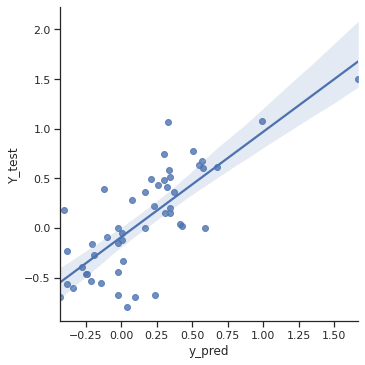

2
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_jobs=30,
                      random_state=42)
50
2-fold :  57.99999999999999
3-fold :  68.0
5-fold :  86.0
gmfe :  2.211517571723094
mfe :  1.2426811055738856
bias :  -0.0818088913457487
rmse  0.4692233522424351
r2  0.3843231406619845


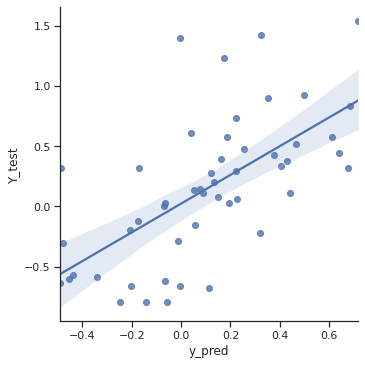

3
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_jobs=30, random_state=42)
50
2-fold :  52.0
3-fold :  78.0
5-fold :  88.0
gmfe :  2.2279731840826464
mfe :  1.334214603733079
bias :  0.14203732004576358
rmse  0.44914609166889846
r2  0.3998196190793706


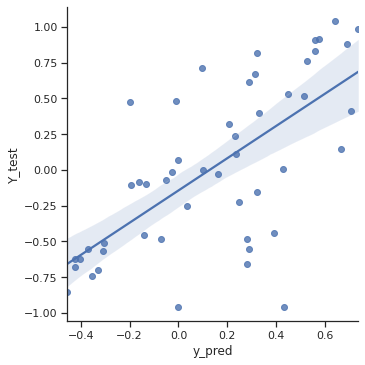

4
(200, 552)
(49, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=42)
49
2-fold :  59.183673469387756
3-fold :  69.38775510204081
5-fold :  85.71428571428571
gmfe :  2.2595137914635828
mfe :  1.1887516192244392
bias :  -0.0544382299450864
rmse  0.5187380899187057
r2  0.394140879165386


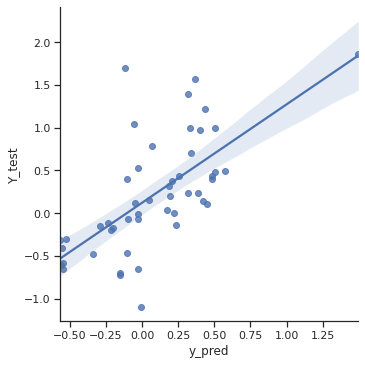

0
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=43)
50
2-fold :  57.99999999999999
3-fold :  72.0
5-fold :  80.0
gmfe :  2.407719740754242
mfe :  1.2863347202775546
bias :  -0.012445017630449251
rmse  0.5240765887929552
r2  0.4394991755919547


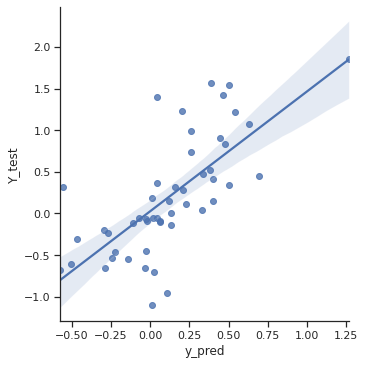

1
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
50
2-fold :  66.0
3-fold :  76.0
5-fold :  90.0
gmfe :  2.120249731279151
mfe :  1.2328229499872119
bias :  -0.18094955036947002
rmse  0.46325261797096984
r2  0.24445221686666962


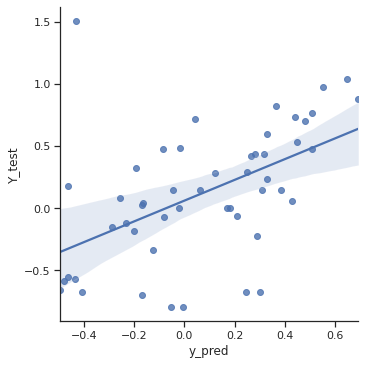

2
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=43)
50
2-fold :  54.0
3-fold :  78.0
5-fold :  92.0
gmfe :  2.0790859612171873
mfe :  1.3020844811963126
bias :  0.26637441006457174
rmse  0.4012280504106309
r2  0.4453719945608555


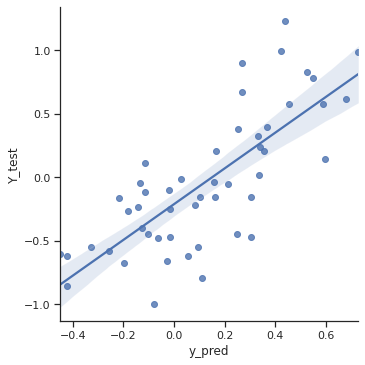

3
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=43)
50
2-fold :  74.0
3-fold :  84.0
5-fold :  94.0
gmfe :  1.857547562242093
mfe :  1.2016416142412014
bias :  -0.01018973368409426
rmse  0.4170834401052099
r2  0.4353642996923265


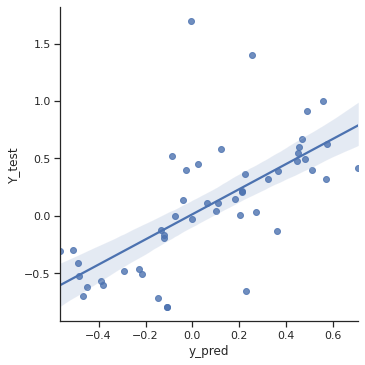

4
(200, 552)
(49, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=43)
49
2-fold :  61.224489795918366
3-fold :  79.59183673469387
5-fold :  87.75510204081633
gmfe :  2.046703847408625
mfe :  1.1972264236512318
bias :  0.04509733337638888
rmse  0.4421563897972677
r2  0.4127643815026405


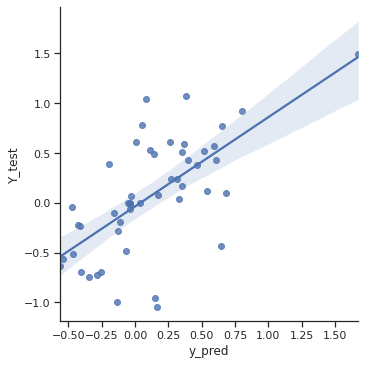

0
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=44)
50
2-fold :  64.0
3-fold :  82.0
5-fold :  94.0
gmfe :  1.984218592856728
mfe :  1.213169657604667
bias :  -0.07552102218573614
rmse  0.4240562992680389
r2  0.4379954387019802


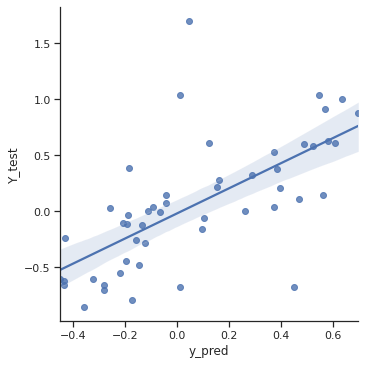

1
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=44)
50
2-fold :  62.0
3-fold :  68.0
5-fold :  82.0
gmfe :  2.1046673999611825
mfe :  1.2241711152298989
bias :  0.07891975856237954
rmse  0.4535207047535481
r2  0.06587858117182144


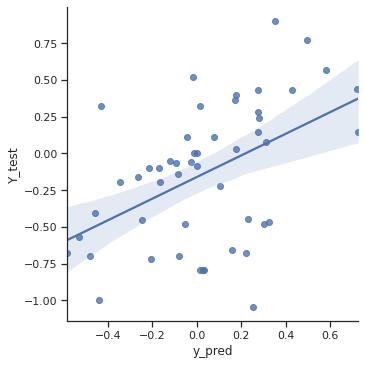

2
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_jobs=30, random_state=44)
50
2-fold :  54.0
3-fold :  80.0
5-fold :  90.0
gmfe :  2.0301720705419104
mfe :  1.2912554173036301
bias :  0.022091912109298548
rmse  0.42621831398536403
r2  0.44390709747386814


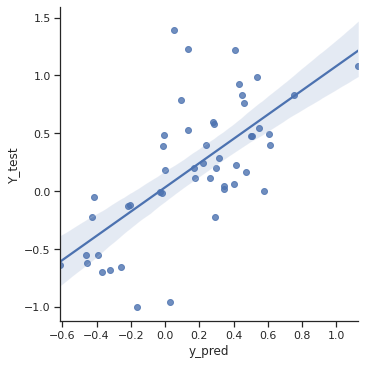

3
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=44)
50
2-fold :  50.0
3-fold :  66.0
5-fold :  78.0
gmfe :  2.651848274506093
mfe :  1.35406190268289
bias :  0.011176829483936335
rmse  0.5993028929625402
r2  0.2830895581375137


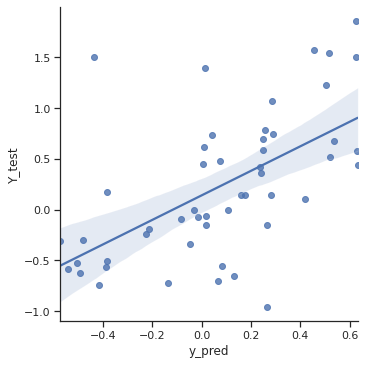

4
(200, 552)
(49, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='log2', n_jobs=30,
                      random_state=44)
49
2-fold :  55.10204081632652
3-fold :  81.63265306122449
5-fold :  91.83673469387756
gmfe :  2.0922296433927476
mfe :  1.3067810899044252
bias :  -0.01638257492202888
rmse  0.41911987409443974
r2  0.3827525452016185


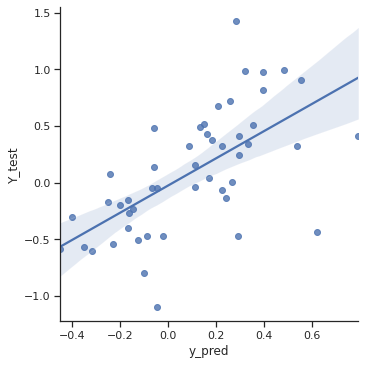

0
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      n_estimators=200, n_jobs=30, random_state=45)
50
2-fold :  48.0
3-fold :  62.0
5-fold :  78.0
gmfe :  2.4595122004497183
mfe :  1.3952590662915423
bias :  -0.042804789390713194
rmse  0.5144830869820946
r2  0.331666486606607


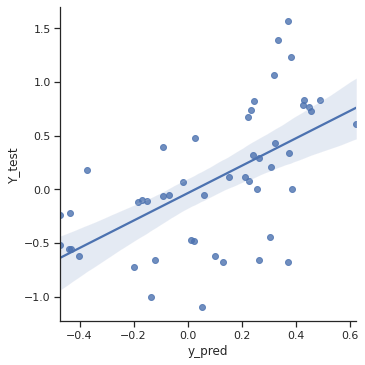

1
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)
50
2-fold :  62.0
3-fold :  76.0
5-fold :  90.0
gmfe :  1.99988227653166
mfe :  1.2080077711882942
bias :  -0.04592536477693682
rmse  0.42416345794969923
r2  0.46633478671040773


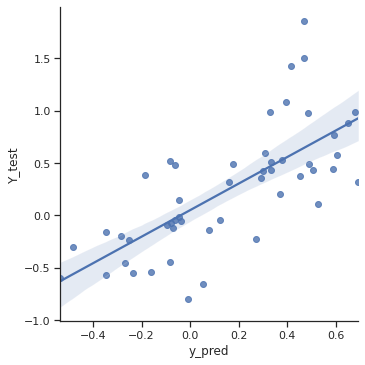

2
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_jobs=30, random_state=45)
50
2-fold :  68.0
3-fold :  76.0
5-fold :  90.0
gmfe :  2.027938404291062
mfe :  1.1891593688691138
bias :  0.1411056792069112
rmse  0.43690602250123206
r2  0.41089922478110774


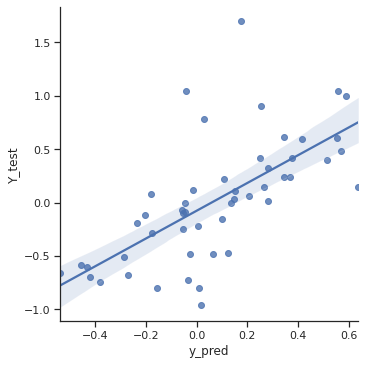

3
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
50
2-fold :  57.99999999999999
3-fold :  74.0
5-fold :  84.0
gmfe :  2.2869436226083475
mfe :  1.29141641717437
bias :  0.0953783127817085
rmse  0.469417902938602
r2  0.3581596373020577


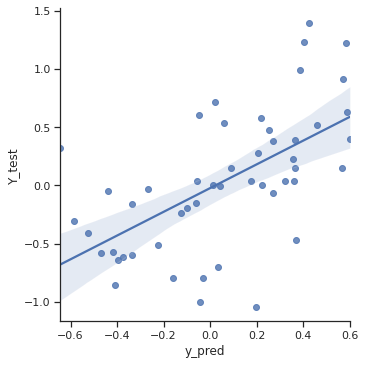

4
(200, 552)
(49, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_jobs=30, random_state=45)
49
2-fold :  69.38775510204081
3-fold :  83.6734693877551
5-fold :  93.87755102040816
gmfe :  1.9502159994856185
mfe :  1.2326601278981804
bias :  0.03396788699155606
rmse  0.4532999609708361
r2  0.3187154906679611


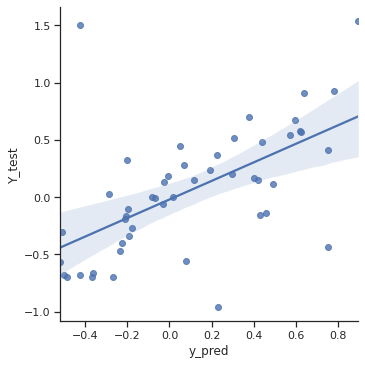

0
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=46)
50
2-fold :  66.0
3-fold :  68.0
5-fold :  90.0
gmfe :  2.2192336413122296
mfe :  1.2634585696017027
bias :  0.19007860133458968
rmse  0.4701497888251625
r2  0.4319244231408098


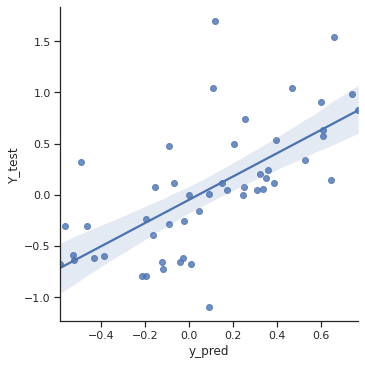

1
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      n_jobs=30, random_state=46)
50
2-fold :  62.0
3-fold :  74.0
5-fold :  94.0
gmfe :  1.9445594014351995
mfe :  1.207854972918258
bias :  -0.12174939176432376
rmse  0.3650302169834951
r2  0.5085003755245248


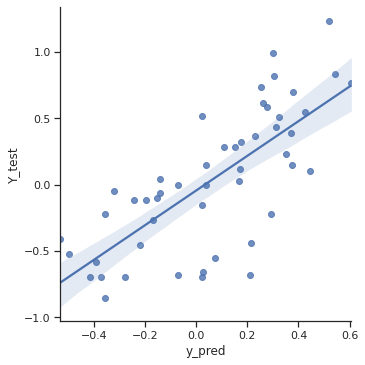

2
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=46)
50
2-fold :  57.99999999999999
3-fold :  64.0
5-fold :  86.0
gmfe :  2.297904226381694
mfe :  1.2571532853589813
bias :  -0.1662610328845896
rmse  0.49579230298883736
r2  0.4127518787494121


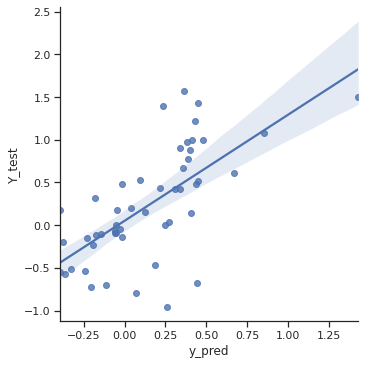

3
(199, 552)
(50, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', n_jobs=30,
                      random_state=46)
50
2-fold :  64.0
3-fold :  80.0
5-fold :  88.0
gmfe :  2.1089817284928825
mfe :  1.2098232540490517
bias :  0.13793663824686242
rmse  0.48959392758832365
r2  0.13920345419065272


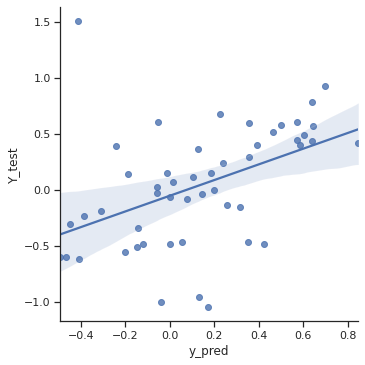

4
(200, 552)
(49, 552)
Running ____________________dog_VDss_L_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=46)
49
2-fold :  63.26530612244898
3-fold :  77.55102040816327
5-fold :  85.71428571428571
gmfe :  2.0212792516666034
mfe :  1.2379488787788093
bias :  0.030197269371764146
rmse  0.4211548066885383
r2  0.4946905908072755


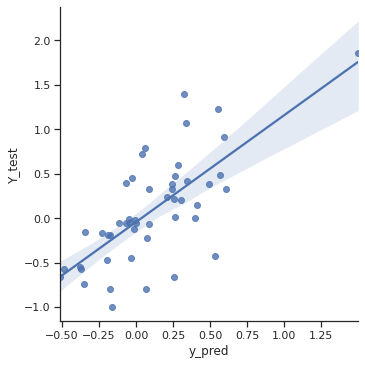

dog_CL_mL_min_kg
0
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=8, n_jobs=30, random_state=42)
51
2-fold :  52.94117647058824
3-fold :  76.47058823529412
5-fold :  86.27450980392157
gmfe :  2.467493127076577
mfe :  1.3143718553662356
bias :  -4.6356159548377205
rmse  0.5559692689541887
r2  0.25731855910591395
saving model


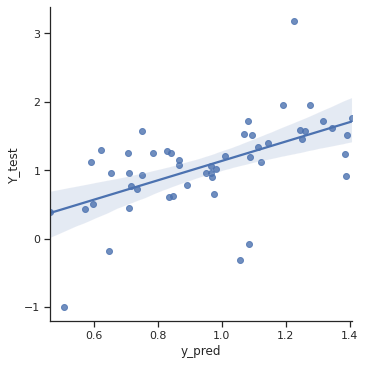

1
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=42)
51
2-fold :  54.90196078431373
3-fold :  74.50980392156863
5-fold :  94.11764705882352
gmfe :  2.1182420150986245
mfe :  1.29068212299818
bias :  0.5283512652082325
rmse  0.4186627575498053
r2  0.3585064339630958
saving model


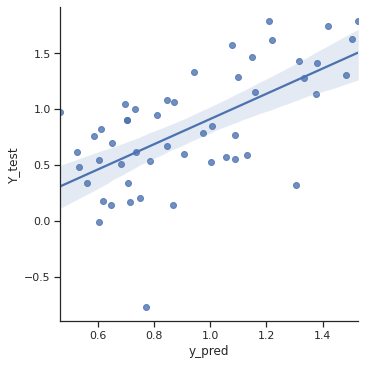

2
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=42)
51
2-fold :  50.98039215686274
3-fold :  78.43137254901961
5-fold :  88.23529411764706
gmfe :  2.2555984335958623
mfe :  1.344189156234177
bias :  -0.5956848571373845
rmse  0.4701594957061613
r2  0.3005003634120581


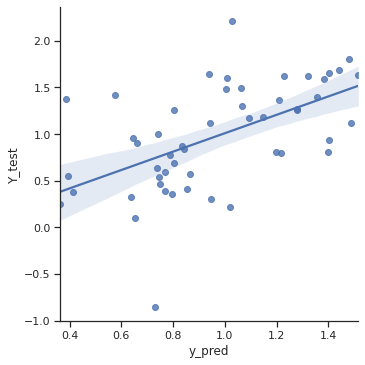

3
(203, 552)
(50, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
50
2-fold :  60.0
3-fold :  68.0
5-fold :  88.0
gmfe :  2.3161950219248455
mfe :  1.2467242429312564
bias :  -0.10449410678480486
rmse  0.5261446122000931
r2  0.14079297395683976


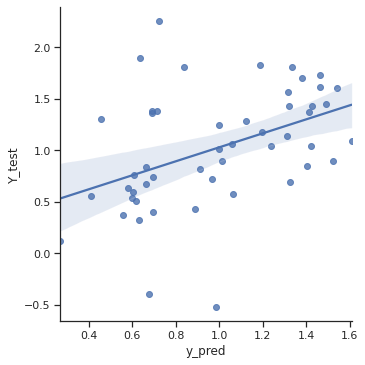

4
(203, 552)
(50, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      n_jobs=30, random_state=42)
50
2-fold :  48.0
3-fold :  70.0
5-fold :  88.0
gmfe :  2.4392249667658454
mfe :  1.355306828949436
bias :  -2.4856659640834793
rmse  0.49979374989630954
r2  0.3002648181182094


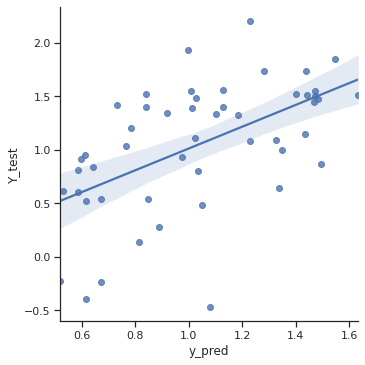

0
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=8, n_jobs=30, random_state=43)
51
2-fold :  68.62745098039215
3-fold :  82.35294117647058
5-fold :  90.19607843137256
gmfe :  1.9948296200955935
mfe :  1.1939651925723984
bias :  -0.9431243877680764
rmse  0.45892929179735886
r2  0.3744443240552864
saving model


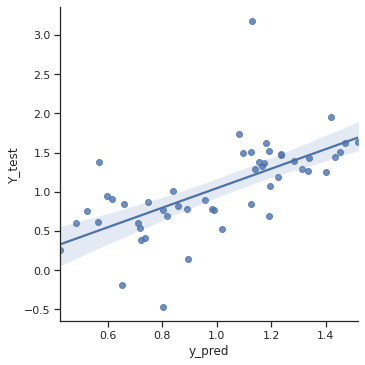

1
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=43)
51
2-fold :  45.09803921568628
3-fold :  64.70588235294117
5-fold :  78.43137254901961
gmfe :  2.7043228397809527
mfe :  1.394065745414196
bias :  -3.52008713030759
rmse  0.5505307234113594
r2  0.15180914382527233


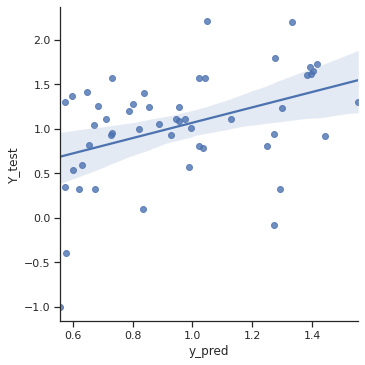

2
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=43)
51
2-fold :  64.70588235294117
3-fold :  74.50980392156863
5-fold :  86.27450980392157
gmfe :  2.4858479440175696
mfe :  1.2781460388848014
bias :  0.9488725415864225
rmse  0.5922712971428242
r2  0.198967262754976


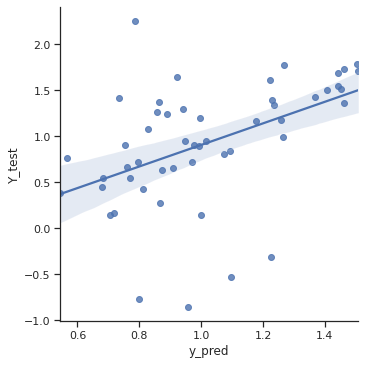

3
(203, 552)
(50, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=43)
50
2-fold :  42.0
3-fold :  66.0
5-fold :  92.0
gmfe :  2.3040757444728026
mfe :  1.4257997134143232
bias :  1.478180131450765
rmse  0.434908848757501
r2  0.4032957500126323


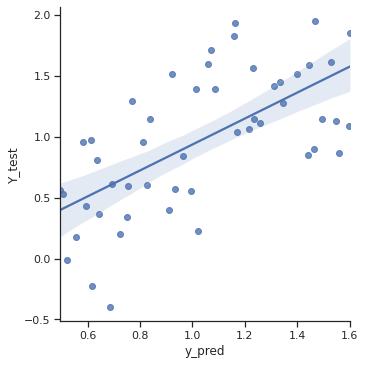

4
(203, 552)
(50, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=43)
50
2-fold :  60.0
3-fold :  76.0
5-fold :  90.0
gmfe :  2.0215678582095458
mfe :  1.2774652963129796
bias :  -0.5818212341775435
rmse  0.3932746481611384
r2  0.4075666069264251


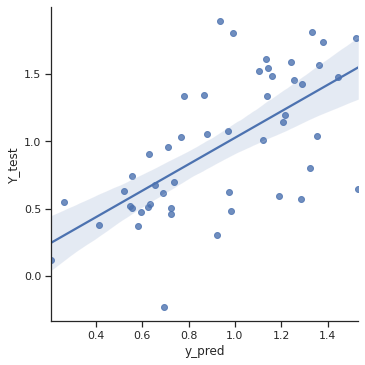

0
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      n_jobs=30, random_state=44)
51
2-fold :  41.17647058823529
3-fold :  64.70588235294117
5-fold :  86.27450980392157
gmfe :  2.5196900390972026
mfe :  1.3961412517440486
bias :  -1.5851147301957074
rmse  0.5192752865776312
r2  0.26991768661626203


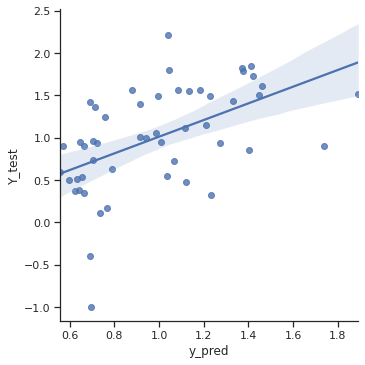

1
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', n_jobs=30,
                      random_state=44)
51
2-fold :  62.745098039215684
3-fold :  76.47058823529412
5-fold :  90.19607843137256
gmfe :  2.066095155284649
mfe :  1.2651682337821968
bias :  -2.1425832596839425
rmse  0.431223740809608
r2  0.25835073181678014


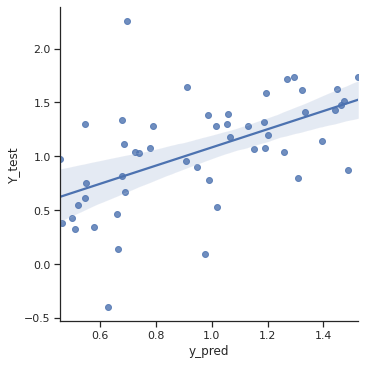

2
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_jobs=30, random_state=44)
51
2-fold :  43.13725490196079
3-fold :  64.70588235294117
5-fold :  80.3921568627451
gmfe :  2.7144988792915714
mfe :  1.4217798414479503
bias :  0.05413335179888179
rmse  0.5371642672733611
r2  0.28017843560606903


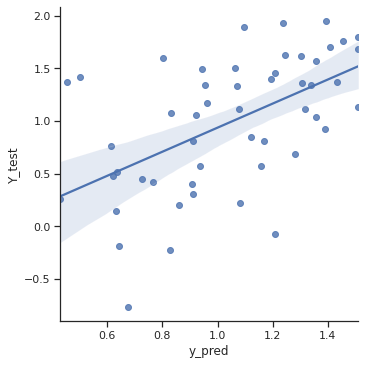

3
(203, 552)
(50, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=44)
50
2-fold :  64.0
3-fold :  88.0
5-fold :  92.0
gmfe :  2.0837794265343565
mfe :  1.235499391020911
bias :  1.8291191612717705
rmse  0.4639770570974924
r2  0.23000784189366674


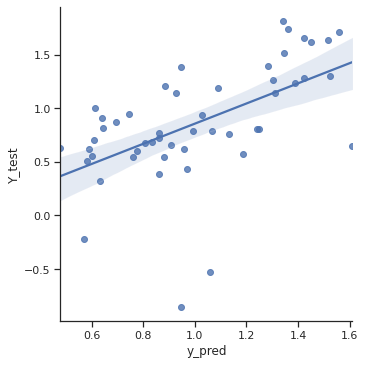

4
(203, 552)
(50, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='log2', min_samples_split=4,
                      n_jobs=30, random_state=44)
50
2-fold :  46.0
3-fold :  74.0
5-fold :  88.0
gmfe :  2.4298199481991247
mfe :  1.3870792288882337
bias :  -3.1404443806429563
rmse  0.5395075152934451
r2  0.27020918930240745


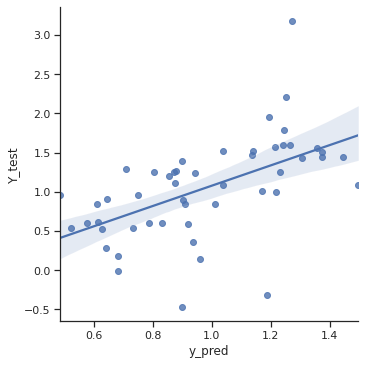

0
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      n_estimators=300, n_jobs=30, random_state=45)
51
2-fold :  50.98039215686274
3-fold :  66.66666666666666
5-fold :  82.35294117647058
gmfe :  2.6496464532140767
mfe :  1.3466068254624612
bias :  0.02266256751361162
rmse  0.5941650279913455
r2  0.2989643807060991


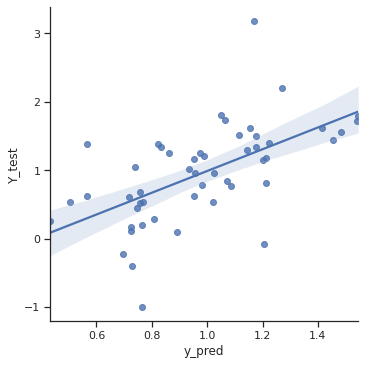

1
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='log2',
                      n_jobs=30, random_state=45)
51
2-fold :  52.94117647058824
3-fold :  78.43137254901961
5-fold :  92.15686274509804
gmfe :  2.1610579574070017
mfe :  1.3291574329229536
bias :  -4.010306660126083
rmse  0.42571725408899785
r2  0.274719157668351


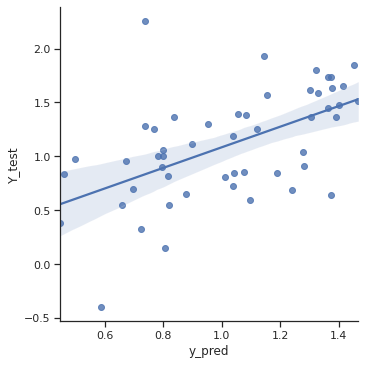

2
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=45)
51
2-fold :  45.09803921568628
3-fold :  78.43137254901961
5-fold :  90.19607843137256
gmfe :  2.2792450952248045
mfe :  1.3756389167832954
bias :  -2.4656649151873147
rmse  0.4613968131369068
r2  0.3089998546196052


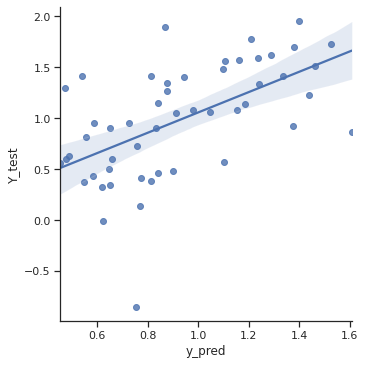

3
(203, 552)
(50, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=5, max_features='log2', min_samples_split=4,
                      n_estimators=200, n_jobs=30, random_state=45)
50
2-fold :  56.00000000000001
3-fold :  72.0
5-fold :  92.0
gmfe :  2.194715798001017
mfe :  1.3150137493213534
bias :  -0.1580775201147433
rmse  0.45006670093622747
r2  0.2558437057655928


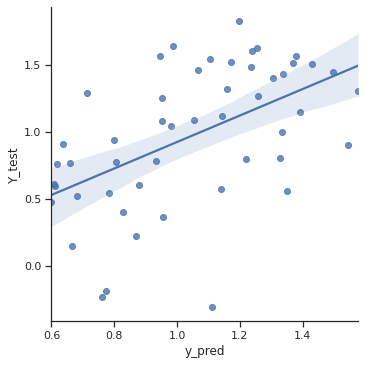

4
(203, 552)
(50, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=45)
50
2-fold :  60.0
3-fold :  76.0
5-fold :  88.0
gmfe :  2.346875066383187
mfe :  1.3027000615473592
bias :  0.3111489159772325
rmse  0.516331353425213
r2  0.27789753278322726


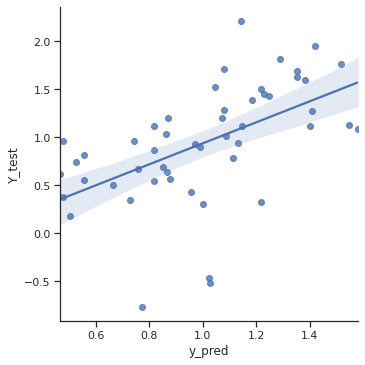

0
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=46)
51
2-fold :  52.94117647058824
3-fold :  64.70588235294117
5-fold :  78.43137254901961
gmfe :  2.8657463970936794
mfe :  1.2960761779983616
bias :  -0.01422978771284722
rmse  0.6415673004557392
r2  0.19000425698942192


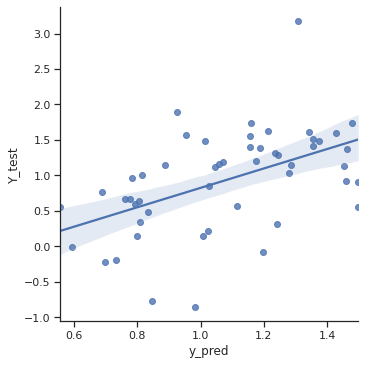

1
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=46)
51
2-fold :  49.01960784313725
3-fold :  72.54901960784314
5-fold :  86.27450980392157
gmfe :  2.5889232606824946
mfe :  1.3688551730215037
bias :  -1.8037915983624497
rmse  0.5416517605875943
r2  0.26252242630534106


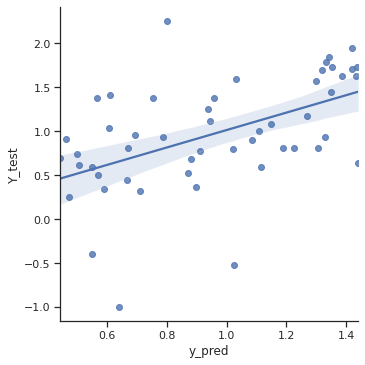

2
(202, 552)
(51, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=4,
                      n_jobs=30, random_state=46)
51
2-fold :  56.86274509803921
3-fold :  78.43137254901961
5-fold :  92.15686274509804
gmfe :  2.183653206548757
mfe :  1.2982209333866732
bias :  -2.824460664982464
rmse  0.4519260979061628
r2  0.3330242583907437


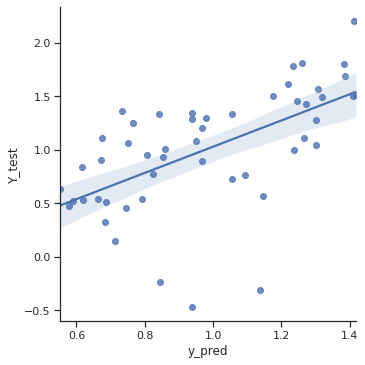

3
(203, 552)
(50, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='log2',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=46)
50
2-fold :  52.0
3-fold :  70.0
5-fold :  86.0
gmfe :  2.375261377103281
mfe :  1.3501449932986396
bias :  -1.2259220984443666
rmse  0.4704759305761768
r2  0.2827826777526127


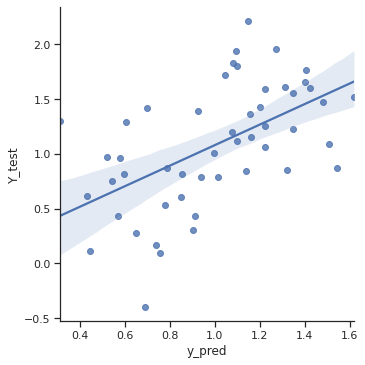

4
(203, 552)
(50, 552)
Running ____________________dog_CL_mL_min_kg MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
50
2-fold :  56.00000000000001
3-fold :  86.0
5-fold :  98.0
gmfe :  1.8537935445859743
mfe :  1.2991465830007949
bias :  0.4635769656079365
rmse  0.32816066792233817
r2  0.4148861368728952
saving model


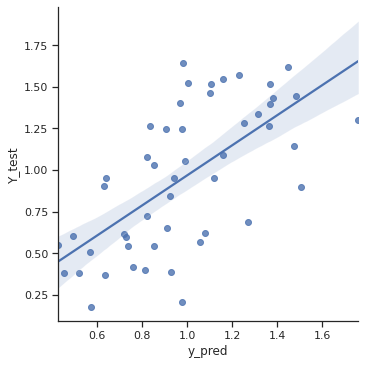

dog_fup
0
(137, 552)
(35, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=42)
35
2-fold :  80.0
3-fold :  85.71428571428571
5-fold :  94.28571428571428
gmfe :  1.7353359301906215
mfe :  1.1616728531119533
bias :  0.01440804290153272
rmse  0.24388342928944276
r2  0.19738575896710053
saving model


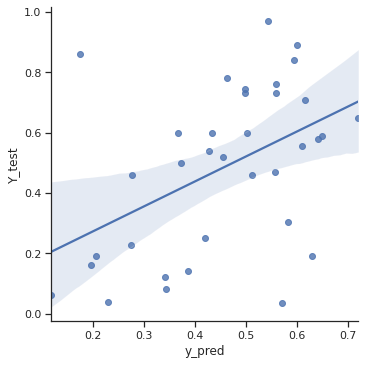

1
(137, 552)
(35, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_estimators=300, n_jobs=30,
                      random_state=42)
35
2-fold :  71.42857142857143
3-fold :  82.85714285714286
5-fold :  88.57142857142857
gmfe :  2.021321380787992
mfe :  1.1850801197623277
bias :  0.03977133135882971
rmse  0.2169225084192418
r2  0.592774595563997


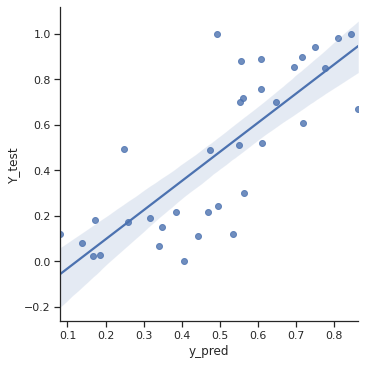

2
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
34
2-fold :  50.0
3-fold :  73.52941176470588
5-fold :  76.47058823529412
gmfe :  2.564434446372002
mfe :  1.3203513900443378
bias :  0.06250285546917017
rmse  0.2687874998686142
r2  0.42013067820428573


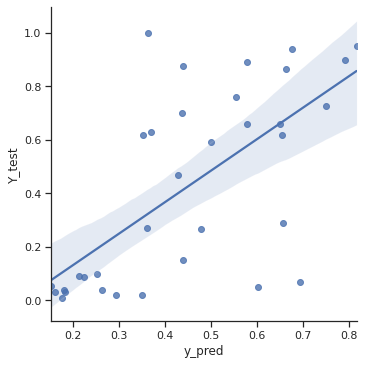

3
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=200, n_jobs=30,
                      random_state=42)
34
2-fold :  61.76470588235294
3-fold :  73.52941176470588
5-fold :  82.35294117647058
gmfe :  2.185729396361827
mfe :  1.1920593946475981
bias :  0.01663200595238102
rmse  0.2106566047033915
r2  0.6083484044661287


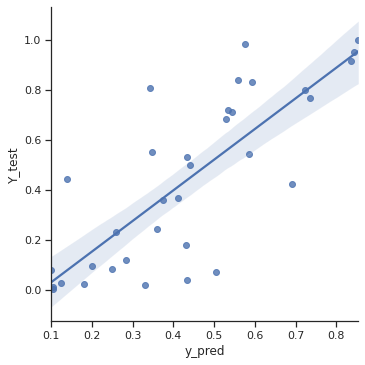

4
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=42)
34
2-fold :  55.88235294117647
3-fold :  67.64705882352942
5-fold :  76.47058823529412
gmfe :  3.6748179718449916
mfe :  1.324768011105405
bias :  0.121365047538773
rmse  0.2615596490164964
r2  0.5113626965265137


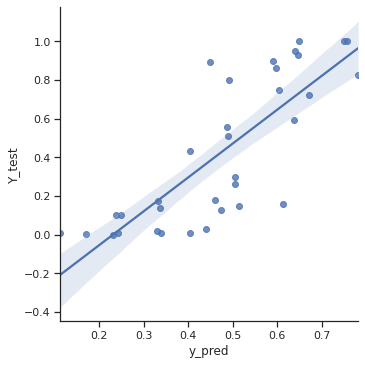

0
(137, 552)
(35, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=43)
35
2-fold :  42.857142857142854
3-fold :  54.285714285714285
5-fold :  71.42857142857143
gmfe :  3.5703979394462717
mfe :  1.4197824301740263
bias :  0.12827741613027488
rmse  0.317458380889206
r2  0.16657004352001714


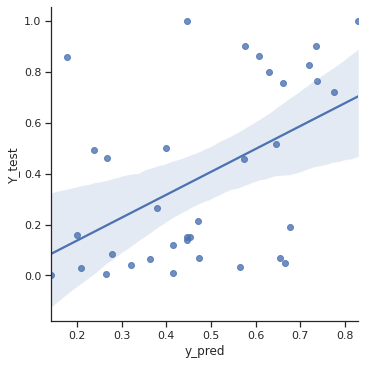

1
(137, 552)
(35, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
35
2-fold :  74.28571428571429
3-fold :  77.14285714285715
5-fold :  85.71428571428571
gmfe :  2.3647379511733106
mfe :  1.182202276960244
bias :  -0.03550016497113945
rmse  0.21848596264524395
r2  0.6139255121292316


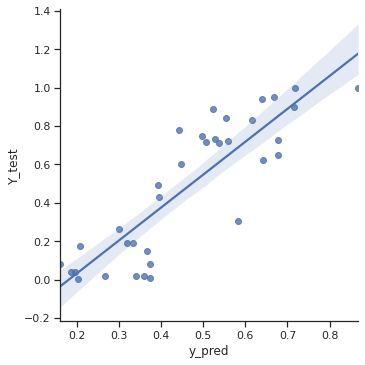

2
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_estimators=200, n_jobs=30,
                      random_state=43)
34
2-fold :  64.70588235294117
3-fold :  73.52941176470588
5-fold :  82.35294117647058
gmfe :  2.6704540153883976
mfe :  1.2192319841089585
bias :  -0.07263953483166002
rmse  0.2624819982743727
r2  0.4319418308574625


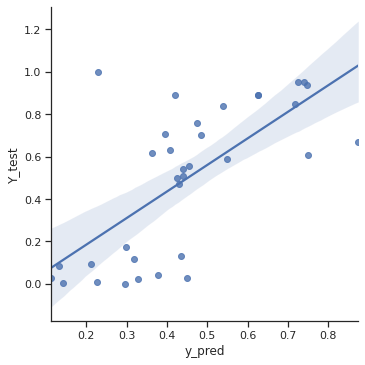

3
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=43)
34
2-fold :  82.35294117647058
3-fold :  88.23529411764706
5-fold :  91.17647058823529
gmfe :  1.6180313735384022
mfe :  1.1380989000830775
bias :  0.016333042248029783
rmse  0.18643436087242427
r2  0.5830620503691051
saving model


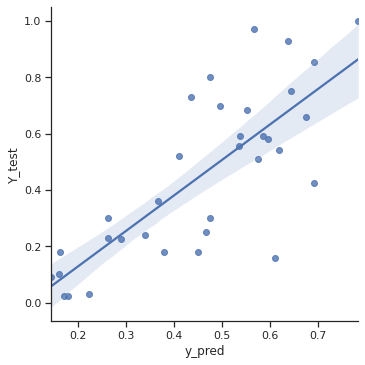

4
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=43)
34
2-fold :  47.05882352941176
3-fold :  76.47058823529412
5-fold :  88.23529411764706
gmfe :  2.260140815447131
mfe :  1.3713696630270684
bias :  0.03237370833333329
rmse  0.2633481039426079
r2  0.3873470586066192


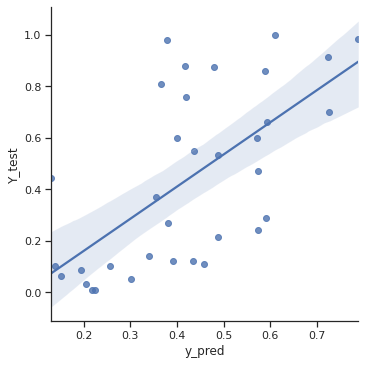

0
(137, 552)
(35, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
35
2-fold :  62.857142857142854
3-fold :  80.0
5-fold :  88.57142857142857
gmfe :  2.0295877250228735
mfe :  1.2269356594223633
bias :  -0.053007933843933985
rmse  0.2756352517829838
r2  0.28745657643229383


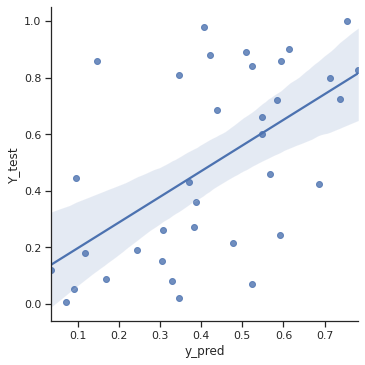

1
(137, 552)
(35, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=44)
35
2-fold :  57.14285714285714
3-fold :  68.57142857142857
5-fold :  74.28571428571429
gmfe :  3.3749813932746595
mfe :  1.3359813340311475
bias :  0.09649606111111098
rmse  0.21710168149400358
r2  0.6008384884776294


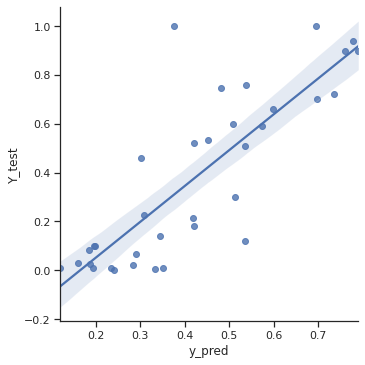

2
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=44)
34
2-fold :  73.52941176470588
3-fold :  79.41176470588235
5-fold :  85.29411764705883
gmfe :  1.9740026432273947
mfe :  1.1249820298455229
bias :  0.0009492932234431081
rmse  0.25692279418430714
r2  0.40362655435008943


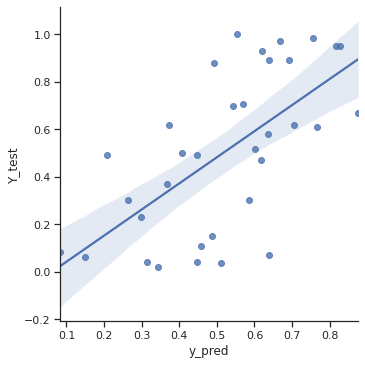

3
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_jobs=30, random_state=44)
34
2-fold :  70.58823529411765
3-fold :  82.35294117647058
5-fold :  88.23529411764706
gmfe :  2.020088032876938
mfe :  1.2018710172396774
bias :  0.0563338257315221
rmse  0.21854814678581344
r2  0.5011540720696974


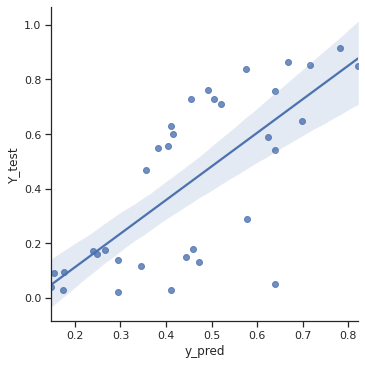

4
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=44)
34
2-fold :  67.64705882352942
3-fold :  70.58823529411765
5-fold :  82.35294117647058
gmfe :  2.599774301496564
mfe :  1.2371162099298816
bias :  0.006849789146633235
rmse  0.23738134172824996
r2  0.5585463571586449


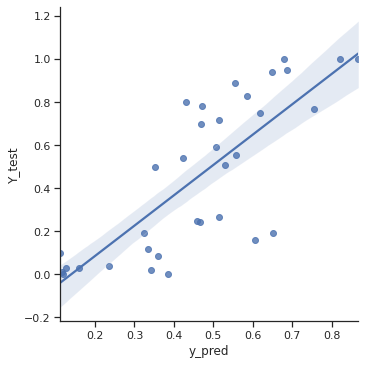

0
(137, 552)
(35, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
35
2-fold :  62.857142857142854
3-fold :  74.28571428571429
5-fold :  80.0
gmfe :  2.2958888546732115
mfe :  1.2263021763508175
bias :  0.055079665996936866
rmse  0.2759974566363124
r2  0.3410551397195818


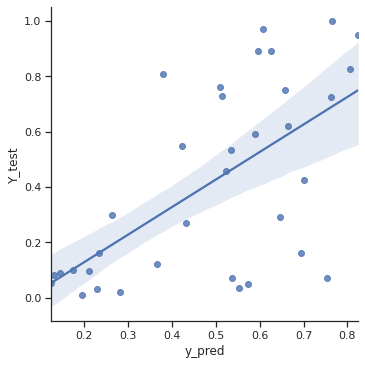

1
(137, 552)
(35, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
35
2-fold :  60.0
3-fold :  65.71428571428571
5-fold :  74.28571428571429
gmfe :  3.174688552394803
mfe :  1.331390291788857
bias :  0.06772280732142869
rmse  0.22857895349025903
r2  0.578081084343189


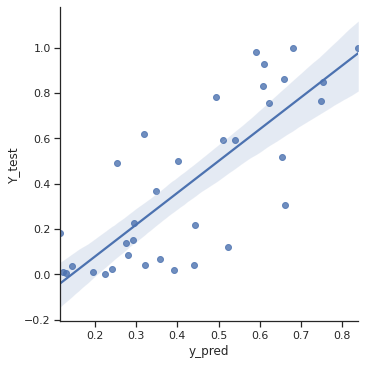

2
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      n_estimators=200, n_jobs=30, random_state=45)
34
2-fold :  70.58823529411765
3-fold :  82.35294117647058
5-fold :  88.23529411764706
gmfe :  2.202581425782387
mfe :  1.2026622231301571
bias :  -0.0724445194183376
rmse  0.24902312592892795
r2  0.4189236359161814


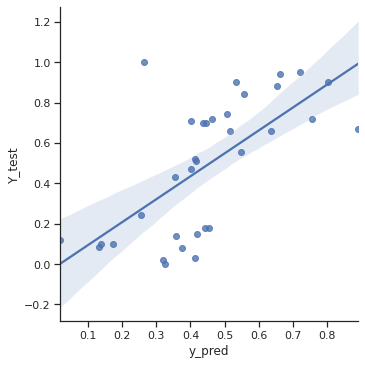

3
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_estimators=300, n_jobs=30,
                      random_state=45)
34
2-fold :  79.41176470588235
3-fold :  82.35294117647058
5-fold :  94.11764705882352
gmfe :  1.81329174510077
mfe :  1.165290670849382
bias :  -0.02704466351010104
rmse  0.20834646566840073
r2  0.5664600805318394


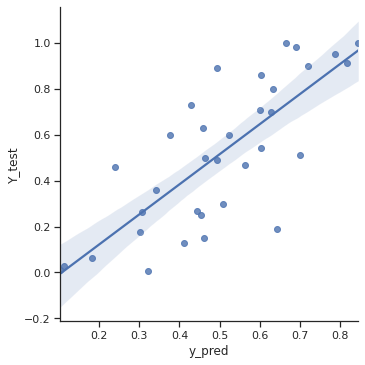

4
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_estimators=300, n_jobs=30, random_state=45)
34
2-fold :  58.82352941176471
3-fold :  67.64705882352942
5-fold :  79.41176470588235
gmfe :  2.4824021427357876
mfe :  1.2761958103536388
bias :  0.009099302910052509
rmse  0.24964920042714941
r2  0.45250599781944056


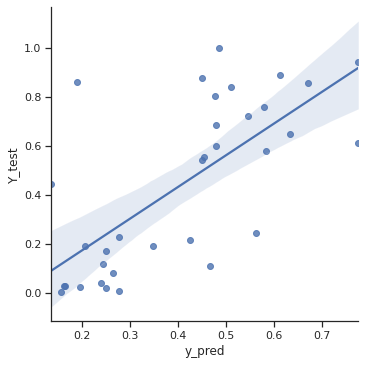

0
(137, 552)
(35, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=46)
35
2-fold :  77.14285714285715
3-fold :  85.71428571428571
5-fold :  85.71428571428571
gmfe :  1.830820526851495
mfe :  1.1327277148103736
bias :  -0.0732700904761906
rmse  0.254035248230601
r2  0.2917711267260382


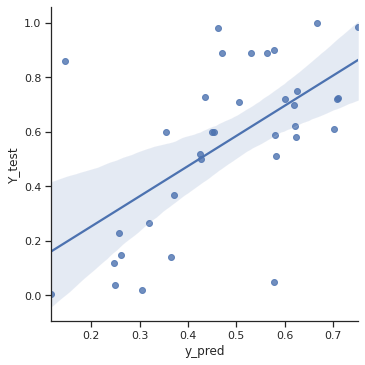

1
(137, 552)
(35, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=8, n_jobs=30, random_state=46)
35
2-fold :  48.57142857142857
3-fold :  60.0
5-fold :  71.42857142857143
gmfe :  3.576535845266601
mfe :  1.367761285138065
bias :  0.09471502380952385
rmse  0.2572815713268509
r2  0.3914026100627991


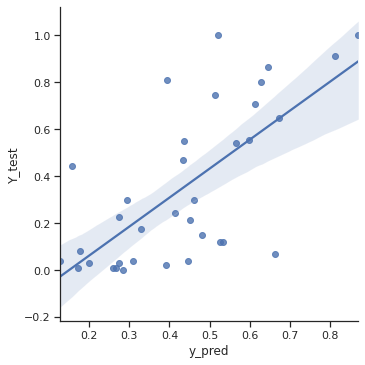

2
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      min_samples_split=4, n_jobs=30, random_state=46)
34
2-fold :  52.94117647058824
3-fold :  70.58823529411765
5-fold :  79.41176470588235
gmfe :  2.8771685799466304
mfe :  1.3014413373032803
bias :  0.07708129166666676
rmse  0.24364639916074934
r2  0.5123477237274112


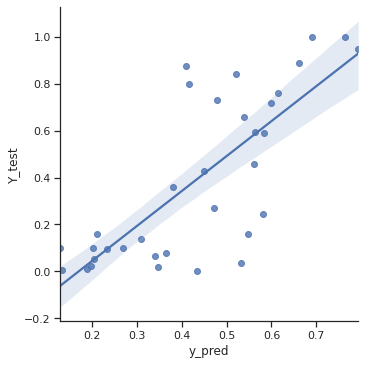

3
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
34
2-fold :  73.52941176470588
3-fold :  85.29411764705883
5-fold :  91.17647058823529
gmfe :  1.8717022512710033
mfe :  1.2007117804534404
bias :  -0.024104500000000084
rmse  0.22391330770350365
r2  0.5188114952986687


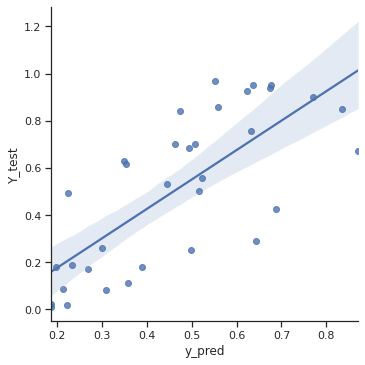

4
(138, 552)
(34, 552)
Running ____________________dog_fup MODELS
Fitting 4 folds for each of 108 candidates, totalling 432 fits
RandomForestRegressor(bootstrap=False, max_depth=15, max_features='sqrt',
                      n_jobs=30, random_state=46)
34
2-fold :  58.82352941176471
3-fold :  70.58823529411765
5-fold :  88.23529411764706
gmfe :  2.161291479077621
mfe :  1.2235494593233118
bias :  0.00290653333333335
rmse  0.25154270435294107
r2  0.4510329609156124


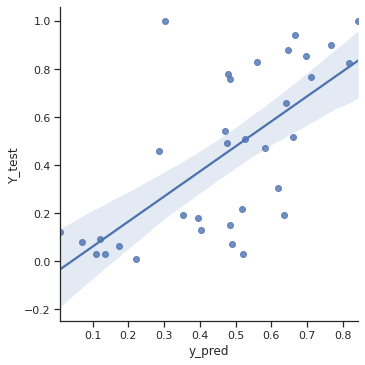

In [24]:
from sklearn.preprocessing import StandardScaler
import pickle
list_of_lists=[]



for endpoint in ["dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup"]:
    
    baseline=10.00
    #log human_VDss_L_kg model
    data = dog_mfp_Mordred
    features = features_mfp_mordred_columns
        

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]
    
    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features)
    
    for i in range(42,47): 
        
        #Nested Cross Validation    
        outercv = KFold(n_splits=5, random_state=i, shuffle=True) 

        for split, (train_index, test_index) in enumerate(outercv.split(X)):
            print(split)

            X_train= X.iloc[train_index].values
            Y_train= Y.iloc[train_index].values.flatten()

            X_test= X.iloc[test_index].values
            Y_test= Y.iloc[test_index].values.flatten()

            print(X_train.shape)
            print(X_test.shape)

            inner_cv = KFold(n_splits=4, random_state=i, shuffle=True) 

            # Create a based model
            regressor = RandomForestRegressor(random_state = i, n_jobs=20)

            # Instantiate the RandomHalving search model
            param_grid = { 
            "n_estimators": [100,200,300],
            "max_features": ["sqrt", "log2"],
            "min_samples_split": [2,4,8],
            "max_depth": [5, 10, 15],    
            "bootstrap": [True, False],
            "n_jobs": [30]
            }

            gsh = GridSearchCV(estimator = regressor, param_grid = param_grid, cv = inner_cv, n_jobs=30, verbose = 1)

            ##MODELS
            print(f"Running ____________________{endpoint} MODELS")

            gsh.fit(X_train, Y_train)
            #print(gsh.best_estimator_)

            #HeldOutTest
            classifier = gsh.best_estimator_
            print(classifier)
            classifier.fit(X_train, Y_train)

            y_pred =  classifier.predict(X_test)     
            print(len(y_pred))

            fold_2= count(y_pred, Y_test, 0.5, 2, endpoint)
            fold_3= count(y_pred, Y_test, 1/3, 3, endpoint)
            fold_5= count(y_pred, Y_test, 1/5, 5, endpoint)
            gmfe = calc_gmfe(y_pred, Y_test, endpoint)
            mfe = median_fold_change_error(y_pred, Y_test, endpoint)
            bias = calc_bias(y_pred, Y_test, endpoint)

            print("2-fold : ", fold_2)
            print("3-fold : ", fold_3)
            print("5-fold : ", fold_5)
            print("gmfe : ", gmfe)
            print("mfe : ", mfe)
            print("bias : ", bias)

            rmse = sqrt(mean_squared_error(Y_test, y_pred))
            print('rmse ',rmse)
            r2 = r2_score(Y_test, y_pred)
            print('r2 ',r2)

            #if (r2>baseline):
            if (gmfe<baseline):
                # save
                print("saving model")
                baseline=gmfe
                pickle.dump(classifier, open(f"log_{endpoint}_model.sav", 'wb'))

            sns.set_theme(style="ticks")
            df=pd.DataFrame({"y_pred":y_pred, "Y_test":Y_test})
            sns.lmplot(data=df, x="y_pred", y="Y_test")
            plt.show()

            row=["HeldOut",  endpoint, i, split, fold_2, fold_3, fold_5, gmfe, mfe, bias, rmse, r2]
            list_of_lists.append(row)


In [25]:
results = pd.DataFrame(list_of_lists, columns=["HeldOut", "endpoint", "random_state", "split", "fold_2", "fold_3", "fold_5", "gmfe", "mfe", "bias", "rmse", "r2"])
results

,HeldOut,endpoint,random_state,split,fold_2,fold_3,fold_5,gmfe,mfe,bias,rmse,r2
0,HeldOut,dog_VDss_L_kg,42,0,68.000000,78.000000,84.000000,2.140764,1.175909,0.064920,0.517044,0.069333
1,HeldOut,dog_VDss_L_kg,42,1,70.000000,84.000000,92.000000,1.840231,1.208961,0.122155,0.348120,0.566532
2,HeldOut,dog_VDss_L_kg,42,2,58.000000,68.000000,86.000000,2.211518,1.242681,-0.081809,0.469223,0.384323
3,HeldOut,dog_VDss_L_kg,42,3,52.000000,78.000000,88.000000,2.227973,1.334215,0.142037,0.449146,0.399820
4,HeldOut,dog_VDss_L_kg,42,4,59.183673,69.387755,85.714286,2.259514,1.188752,-0.054438,0.518738,0.394141
...,...,...,...,...,...,...,...,...,...,...,...,...
70,HeldOut,dog_fup,46,0,77.142857,85.714286,85.714286,1.830821,1.132728,-0.073270,0.254035,0.291771
71,HeldOut,dog_fup,46,1,48.571429,60.000000,71.428571,3.576536,1.367761,0.094715,0.257282,0.391403
72,HeldOut,dog_fup,46,2,52.941176,70.588235,79.411765,2.877169,1.301441,0.077081,0.243646,0.512348
73,HeldOut,dog_fup,46,3,73.529412,85.294118,91.176471,1.871702,1.200712,-0.024105,0.223913,0.518811


In [26]:
results.to_csv("Prediction_dog_from_mordred_morgan_fs.csv", index=False)

In [27]:
import pickle
import pandas as pd
results= pd.read_csv("Prediction_dog_from_mordred_morgan_fs.csv")
results.groupby("endpoint").mean().reset_index().to_csv("dog.csv", index=False)
results.groupby("endpoint").mean()

,random_state,split,fold_2,fold_3,fold_5,gmfe,mfe,bias,rmse,r2
endpoint,,,,,,,,,,
dog_CL_mL_min_kg,44.0,2.0,53.446275,73.683137,88.158431,2.336808,1.324318,-1.064042,0.490930,0.284071
dog_VDss_L_kg,44.0,2.0,60.966531,75.193469,87.795918,2.134836,1.250112,0.022918,0.456491,0.371123
dog_fup,44.0,2.0,64.191597,75.136134,83.512605,2.438008,1.242781,0.021635,0.243905,0.455475


In [28]:
# load
loaded_rf = pickle.load(open("log_dog_VDss_L_kg_model.sav", 'rb'))

In [29]:
loaded_rf

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=42)

In [30]:
params = loaded_rf.get_params()

In [31]:
classifier= RandomForestRegressor(**params)
classifier

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=42)

In [32]:
classifier.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='log2',
                      min_samples_split=4, n_jobs=30, random_state=42)

In [33]:
classifier.predict(X_test) 

array([0.04339552, 0.56559935, 0.50125189, 0.60012393, 0.62731802,
       0.43944365, 0.54761277, 0.19055473, 0.58864261, 0.17796696,
       0.18616154, 0.4542848 , 0.48282198, 0.6447496 , 0.58607834,
       0.29428354, 0.13191439, 0.44304254, 0.68327596, 0.78708586,
       0.48330735, 0.31417005, 0.51787575, 0.63788993, 0.68689103,
       0.19338583, 0.74322104, 0.44916091, 0.49699356, 0.72851723,
       0.84080327, 0.51262214, 0.25765698, 0.44212322])

In [34]:
import pickle
list_of_lists=[]


for endpoint in ["dog_VDss_L_kg","dog_CL_mL_min_kg","dog_fup"]:
    
    baseline=10.00
    #log human_VDss_L_kg model
    data = dog_mfp_Mordred
    features = features_mfp_mordred_columns
        

    print(endpoint)    
    df = data.dropna(subset=[endpoint]).reset_index(drop=True)

    X = df[features]
    Y = df[endpoint]

    # Scale the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X = pd.DataFrame(X, columns=features)
    
    # Save the scaler to a file
    with open('scaler_dog.pkl', 'wb') as file:
        pickle.dump(scaler, file)
    
    X_train= X.values
    Y_train= Y.values.flatten()

    print(X_train.shape)
    print(X_test.shape)

          
    loaded_rf = pickle.load(open(f"log_{endpoint}_model.sav", 'rb'))
    params = loaded_rf.get_params()
    
    classifier= RandomForestRegressor(**params)
    classifier.fit(X_train, Y_train)
    
    pickle.dump(classifier, open(f"log_{endpoint}_model_FINAL.sav", 'wb'))

dog_VDss_L_kg
(249, 552)
(34, 552)
dog_CL_mL_min_kg
(253, 552)
(34, 552)
dog_fup
(172, 552)
(34, 552)
